## Calibração de modelos de Classificação binária

In [127]:
import warnings
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, log_loss

from sklearn.calibration import calibration_curve

warnings.simplefilter('ignore')

%config IPCompleter.use_jedi = False

Treinei meu modelo de classificação binária, computei várias métricas: ROC AUC, KS, GINI. O modelo está discriminando muito bem. Eu deveria estar satisfeito, certo? A resposta é depende: o seu modelo está calibrado? Ou melhor ainda, seu modelo precisa estar calibrado?

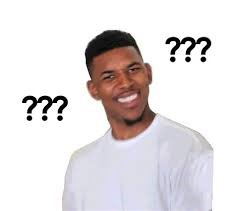

In [129]:
Image(filename='question_meme.jpg') 

Antes de prosseguir, é necessário entender a diferença entre os conceitos de **poder** e de **calibração**. Dentro do contexto de classificação binária, **Poder** tem a ver com a capacidade de um modelo discriminar os eventos positivos dos negativos, claro. As métricas que listamos antes são métricas que avaliam **poder**. O ROC AUC, por exemplo, tem uma interpretação simples que reflete exatamente **poder** que o modelo tem de discriminar eventos: *é a probabilidade de um evento positivo escolhido aleatoriamente ter maior probabilidade output que a de um evento negativo também escolhido aleatoriamente* [1]. O problema é que estas métricas pouco dizem sobre a **confiança** que podemos ter nas probabilidades *outputs* dos modelos. Aí fica a pergunta, como avaliar o quão confiáveis são estas probabilidades?

In [66]:
X, y = make_classification(n_samples=60000,
                           n_classes=2,
                           n_clusters_per_class=1,
                           n_informative=7, 
                           n_redundant=10,
                           class_sep=0.5,
                           random_state=42)
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_tmp, y_tmp, test_size=0.2, random_state=42)

In [67]:
models = {
    "Logistic Regression":  LogisticRegression(random_state=2),
    "Naive Bayes": GaussianNB(var_smoothing=0.001),
    "Random Forest": RandomForestClassifier(max_depth=4, n_estimators=5, random_state=42)
}

_ = list(map(lambda model: model.fit(X_train, y_train), models.values()))

Vamos ver na prática. Segue um cenário no qual treinamos 3 classificadores: uma regressão logística, um Naive Bayes e um Random Forest. Checamos o ROC AUC e *voilà*! O Random Forest parece ser o melhor classificador:

Treinei meu modelo de classificação binária, computei várias métricas: precisão, sensibilidade, ROC AUC, KS. O modelo está discriminando os registros positivos muito bem. Eu deveria estar satisfeito, certo? A resposta é depende: o seu modelo está calibrado? Ou melhor ainda, seu modelo precisa estar calibrado?

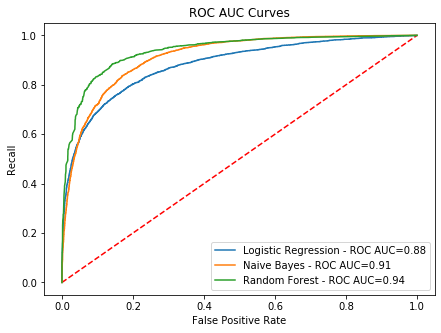

In [68]:
plt.figure(figsize=(7,5))
plt.title("ROC AUC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("Recall")
plt.plot([0, 1], [0, 1],'r--')
for model_name, model in models.items():
    auc = roc_auc_score(y_validation, model.predict_proba(X_validation)[:, 1])
    fpr, tpr, thresholds = roc_curve(y_validation, model.predict_proba(X_validation)[:, 1])
    plt.plot(fpr, tpr, label=f"{model_name} - ROC AUC={auc:.2f}")
plt.legend()
plt.show()

Mas voltando ao ponto sobre as probabilidades, como elas estão? Veja a seguinte análise:

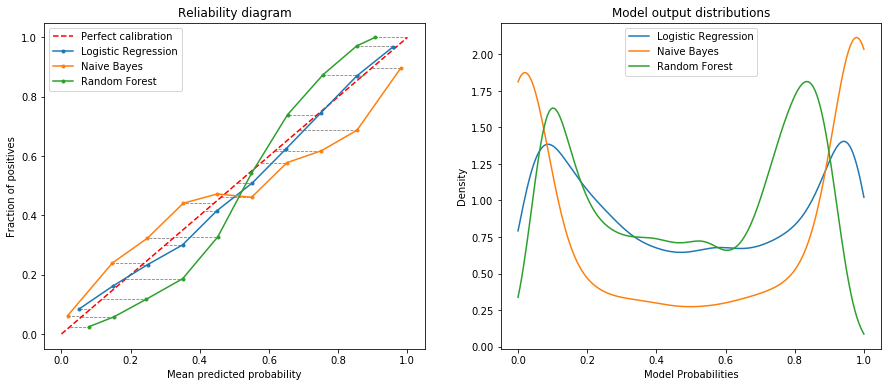

In [99]:
fig, axs = plt.subplots(1, 2)

axs[0].set_title("Reliability diagram")
axs[0].set_ylabel("Fraction of positives")
axs[0].set_xlabel("Mean predicted probability")
axs[0].plot([0, 1], [0, 1],'r--', label=f"Perfect calibration")
# axs[0].axhline(y_validation.mean(), linestyle='--', linewidth=0.7, label='Target mean')
for model_name, model in models.items():
    fraction_of_positives, mean_predicted_prob = calibration_curve(
        y_validation,
        model.predict_proba(X_validation)[:,1], n_bins=10
    )
    axs[0].plot(mean_predicted_prob, fraction_of_positives, '.-', label=f"{model_name}")
    axs[0].hlines(
        y=fraction_of_positives,
        xmin=fraction_of_positives,
        xmax=mean_predicted_prob,
        ls='--',
        color='gray',
        lw=0.8,
    )
axs[0].legend()

axs[1].set_title("Model output distributions")
_ = list(map(lambda model: sns.kdeplot(x=model.predict_proba(X_validation)[:, 1], ax=axs[1], clip=[0, 1]), models.values()))
axs[1].legend(models.keys())
axs[1].set_xlabel("Model Probabilities")

fig.set_size_inches(15, 6)

plt.show()

O primeiro gráfico é chamado de Reliability diagram e contém a informação do quão confiável são as nossas probabilidades. Observe que apesar de ter o pior ROC AUC, a regressão logística é o classificador mais próximo da calibração ideal, tendo as probabilidades mais confiáveis. Ainda nesse plot, veja que quanto maiores forem as linhas pontilhadas em cinza, maior o erro na estimação das probabilidades, ou seja, menor a confiança. Um ponto interessante que notamos no segundo gráfico é que os picos na distribuição do Random Forest ficaram mais distantes das extremidades, enquanto os do Naive Bayes se aproximam das extremidades. Isso não é mero acaso, estes algoritmos, por construção, costumam apresentar este comportamento. No caso do Random Forest, dificilmente o **todas** as árvores irão classificar uma observação como positiva ou negativa. Isso faz com que o algorítimo, no geral, subestime as probabilidades de observações positivas e superestime as probabilidades de observações negativas. O pressuposto da *independência condicional*, no caso do Naive Bayes, por sua vez, gera um efeito inverso, o algoritmo superestima as probabilidades das observações positivas e subestima a das negativas. 

Por último, a Logística, por construção, tenderá a possuir uma boa calibração – recorde que seu treinamento é feito maximizando a verossimilhança, que é equivalente a minimizar a divergência de Kullback-Leibler. Isso no fundo significa que o treinamento está tentando minimizar a distância entre a distribuição de probabilidade estimada e a distribuição que gerou aquela amostra – o naturalmente resultará em uma boa calibração. 

Ufa! Muito bacana! Então isso significa que se eu estou interessado em discriminar melhor os registros positivos eu deveria escolher o Random Forest, mas se eu estiver interessado nos valores exato das probabilidades eu deveria escolher a Logística, correto? Calma lá, *padawan*! 

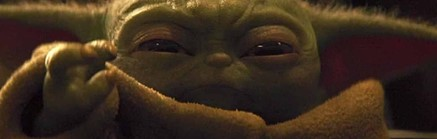

In [130]:
Image(filename='grogu.jpg') 

Existe um jeito de ter o melhor dos dois mundos: calibração!

In [ ]:
rf = list( models.items())[2][1]
outputs = rf.predict_proba(X_test)[:,1]
platt = LogisticRegression(random_state=42)
platt.fit(outputs.reshape(-1, 1), y_test)

Um dos jeitos mais simples de se calibrar um modelo é aplicar uma Logística em cima das probabilidades de um classificador mais poderoso como o Random Forest. Essa técnica é chamada de Platt Scaling. Veja o efeito:

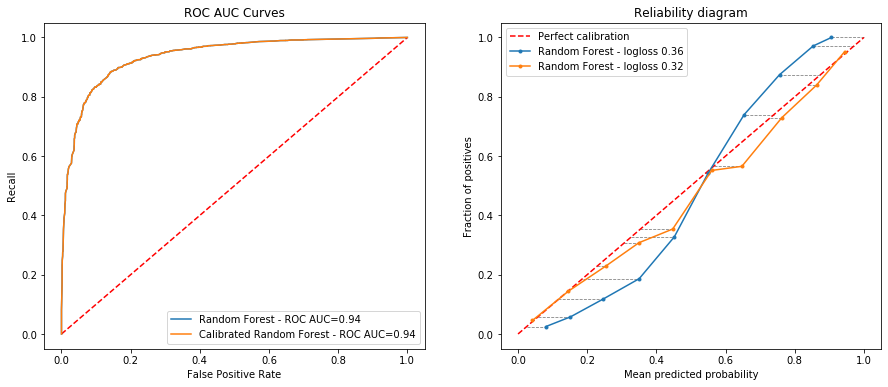

In [123]:
fig, axs = plt.subplots(1, 2)

axs[0].set_title("ROC AUC Curves")
axs[0].set_xlabel("False Positive Rate")
axs[0].set_ylabel("Recall")
axs[0].plot([0, 1], [0, 1],'r--')

auc = roc_auc_score(y_validation, rf.predict_proba(X_validation)[:, 1])
fpr, tpr, thresholds = roc_curve(y_validation, model.predict_proba(X_validation)[:, 1])
axs[0].plot(fpr, tpr, label=f"Random Forest - ROC AUC={auc:.2f}")

outputs = platt.predict_proba(rf.predict_proba(X_validation)[:,1].reshape(-1, 1))[:,1]
auc = roc_auc_score(y_validation, outputs)
fpr, tpr, thresholds = roc_curve(y_validation, outputs)
axs[0].plot(fpr, tpr, label=f"Calibrated Random Forest - ROC AUC={auc:.2f}")
axs[0].legend()

axs[1].set_title("Reliability diagram")
axs[1].set_ylabel("Fraction of positives")
axs[1].set_xlabel("Mean predicted probability")
axs[1].plot([0, 1], [0, 1],'r--', label=f"Perfect calibration")

fraction_of_positives, mean_predicted_prob = calibration_curve(
    y_validation,
    model.predict_proba(X_validation)[:,1], n_bins=10
)
logloss = log_loss(y_validation, model.predict_proba(X_validation)[:,1])
axs[1].plot(mean_predicted_prob, fraction_of_positives, '.-', label=f"Random Forest - logloss {logloss:.2f}")
axs[1].hlines(
    y=fraction_of_positives,
    xmin=fraction_of_positives,
    xmax=mean_predicted_prob,
    ls='--',
    color='gray',
    lw=0.8,
)
    
fraction_of_positives, mean_predicted_prob = calibration_curve(
    y_validation,
    outputs, n_bins=10
)
logloss = log_loss(y_validation, outputs)
axs[1].plot(mean_predicted_prob, fraction_of_positives, '.-', label=f"Random Forest - logloss {logloss:.2f}")
axs[1].hlines(
    y=fraction_of_positives,
    xmin=fraction_of_positives,
    xmax=mean_predicted_prob,
    ls='--',
    color='gray',
    lw=0.8,
)

axs[1].legend()

fig.set_size_inches(15, 6)

plt.show()

Note que não há alteração no poder discriminativo do modelo, o ROC AUC continua o mesmo. A calibração, apesar de algumas em discrepâncias, está bem melhor: a curva está muito mais próxima da calibração perfeita. Isso fica evidente quando calculamos a log loss.

Por último, conseguimos calibrar um modelo com bastante poder, será possível tornar um modelo calibrado poderoso? Infelizmente, esse não é o caso. Então, pelo menos por hora, diga adeus à Regressão Logística (a primeira é claro!).